# Desafio 2 - Maratona Behind the Code 2021

## Bibliotecas

In [1]:
import os
from datetime import timedelta
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor,
                              ExtraTreesRegressor, GradientBoostingRegressor,
                              RandomForestRegressor, StackingRegressor)
from sklearn.linear_model import BayesianRidge, ElasticNet, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV  # , RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor

Se necessário, instale o cloudant:

In [2]:
# !pip install cloudant

## Configurações

In [3]:
seed = 0

## Dados

### Obtenção dos dados de IOT

In [4]:
def get_df(file_name):
    try:
        # When running locally
        result = pd.read_csv(file_name)
    except FileNotFoundError:
        try:
            # When running on IBM cloud
            from project_lib import Project

            PROJECT_ID = os.getenv("PROJECT_ID")
            PROJECT_ACCESS_TOKEN = os.getenv("PROJECT_ACCESS_TOKEN")
            project = Project(
                project_id=PROJECT_ID, project_access_token=PROJECT_ACCESS_TOKEN
            )
            try:
                # When available on assets
                result = read_from_assets(project, file_name)
            except RuntimeError as e:
                # When not available on assets
                df = get_from_cloudant()
                project.save_data(file_name=file_name, data=df.to_csv(index=False))
                result = read_from_assets(project, file_name)
        except ModuleNotFoundError:
            df = get_from_cloudant()
            df.to_csv(file_name, index=False)
            result = pd.read_csv(file_name)
    return result


def read_from_assets(project, file_name):
    file = project.get_file(file_name)
    file.seek(0)
    return pd.read_csv(file)


def get_from_cloudant():
    print("Getting data from cloudant...")
    from cloudant import Cloudant

    CLOUDANT_USER = os.getenv("CLOUDANT_USER")
    CLOUDANT_PASSWORD = os.getenv("CLOUDANT_PASSWORD")
    client = Cloudant(
        CLOUDANT_USER,
        CLOUDANT_PASSWORD,
        account=CLOUDANT_USER,
        connect=True,
        auto_renew=True,
    )
    db = client["quanam-iot"]
    response = db.all_docs(include_docs=True)
    docs = [row["doc"] for row in response["rows"]]
    challenge_columns = ["ID", "ILLUM", "HUMID", "CO2", "SOUND", "TEMP", "RYTHM"]
    return pd.DataFrame(docs)[challenge_columns].copy()

In [5]:
df = get_df("iot.csv")

### Informações gerais

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      3200 non-null   int64  
 1   ILLUM   3200 non-null   float64
 2   HUMID   3200 non-null   float64
 3   CO2     3200 non-null   float64
 4   SOUND   3200 non-null   float64
 5   TEMP    3200 non-null   float64
 6   RYTHM   3200 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 175.1 KB


Neste conjunto de dados:
- Todas as variáveis (colunas) são numéricas.
- Não há dados faltantes.

### Divisão entre treino e teste

Antes de inspecionar os dados, serão reservados alguns exemplos para teste, que não serão vistos durante a análise ou modelagem dos dados:

In [7]:
test_size = 500
target = "RYTHM"
df_train, df_test = train_test_split(df, test_size=test_size, random_state=seed)
print(f"Dimensões dos dados de treino: {df_train.shape}")
print(f"Dimensões dos dados de teste: {df_test.shape}")

Dimensões dos dados de treino: (2700, 7)
Dimensões dos dados de teste: (500, 7)


### Dados de exemplo

In [8]:
with pd.option_context("display.max_rows", 4):
    display(df_train)

,ID,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM
953,761,542.20,73.02,394.17,32.23,19.85,77.74
1633,2769,495.97,71.16,572.84,39.30,18.21,83.36
...,...,...,...,...,...,...,...
2607,1396,321.95,66.36,449.71,22.12,20.63,74.34
2732,2990,553.35,61.47,495.48,32.51,18.17,83.19


### Variável destino

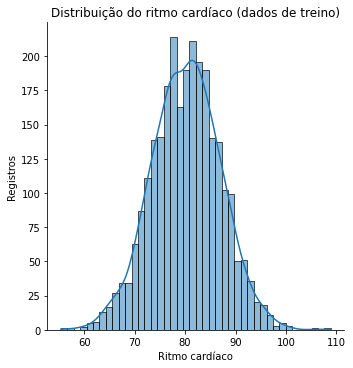

In [9]:
sns.displot(df_train[target], kde=True)
plt.xlabel("Ritmo cardíaco")
plt.ylabel("Registros")
plt.title("Distribuição do ritmo cardíaco (dados de treino)")
plt.show()

### Estatísticas

In [10]:
df_train.describe()

,ID,ILLUM,HUMID,CO2,SOUND,TEMP,RYTHM
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.00000,2700.000000
mean,1599.107037,440.199700,67.121793,501.447263,29.768244,20.04547,80.212707
std,928.089673,89.861751,4.787193,43.007247,6.144921,1.66544,6.759542
min,1.000000,145.480000,51.860000,352.820000,8.060000,14.76000,55.370000
25%,790.750000,377.692500,63.770000,470.540000,25.490000,18.90000,75.730000
50%,1603.000000,437.745000,66.950000,502.005000,29.795000,20.05000,80.280000
75%,2403.250000,501.452500,70.410000,530.140000,33.850000,21.20000,84.712500
max,3200.000000,775.140000,83.900000,672.380000,53.780000,26.29000,108.900000


### Correlações

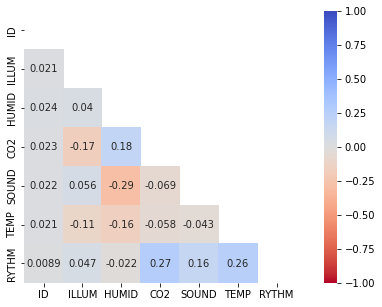

In [11]:
plt.subplots(figsize=(10, 5))
corr = df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, square=True, vmin=-1.0, vmax=1.0, cmap="coolwarm_r", mask=mask)
plt.show()

- O ritmo cardíaco tem maior correlação positiva com os níveis de CO2, e negativa com a umidade

In [12]:
# sns.pairplot(df_train.drop('ID', axis=1), hue=target, corner=True, palette="coolwarm_r")
# plt.show()

In [13]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', Lasso(random_state=seed))
])

In [14]:
X_train = df_train.drop(target, axis=1)
y_train = df_train[target]
X_test = df_test.drop(target, axis=1)
y_test = df_test[target]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2700, 6)
(2700,)
(500, 6)
(500,)


In [15]:
param_grid = [
    {
    'clf': [Lasso(alpha=0.0005, max_iter=100, positive=True, random_state=seed)],
    'scaler': [MinMaxScaler()],
    },
    # {
    # 'clf': [BayesianRidge(alpha_1=1.0, alpha_2=0.000001, lambda_1=0.000001, lambda_2=1.0)],
    # 'scaler': [RobustScaler()],
    # },
    # {
    # 'clf': [KNeighborsRegressor(n_neighbors=29, weights='uniform')],
    # 'scaler': [RobustScaler()],
    # },
    {
    'clf': [BaggingRegressor(random_state=seed)],
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    'clf__n_estimators': [10, 25, 50, 100, 150, 200],
    'clf__max_samples': [0.3, 0.5, 0.8, 0.9, 1.0],
    'clf__max_features': [0.3, 0.5, 0.8, 0.9, 1.0],
    'clf__bootstrap': [True, False],
    },
    # {
    # 'clf': [ExtraTreesRegressor(max_depth=10, max_features=0.95, max_samples=0.3, n_estimators=200, bootstrap=True, criterion='mse', random_state=seed)],
    # 'scaler': [StandardScaler()],
    # },
    # {
    # 'clf': [AdaBoostRegressor(n_estimators=100, learning_rate=0.05, random_state=seed,
    #                           base_estimator=DecisionTreeRegressor(max_depth=5, random_state=seed))],
    # 'scaler': [MinMaxScaler()],
    # },
    # {
    # 'clf': [ElasticNet(alpha=0.008, random_state=seed)],
    # 'scaler': [RobustScaler()],
    # },
    # {
    # 'clf': [Ridge(alpha=0.4, random_state=seed)],
    # 'scaler': [MinMaxScaler()],
    # },
    # {
    # 'clf': [GradientBoostingRegressor(alpha=0.001, learning_rate=0.13, max_depth=1, n_estimators=165, random_state=seed)],
    # 'scaler': [StandardScaler()],
    # },
    # {
    # 'clf': [RandomForestRegressor(criterion='mae', max_features=0.45, n_estimators=330, random_state=seed)],
    # 'scaler': ['passthrough'],
    # },
    # {
    # 'clf': [
    #     StackingRegressor(
    #         estimators=[
    #             ('ridge', Ridge(alpha=0.4, random_state=seed)),
    #             ('elast', ElasticNet(alpha=0.008, random_state=seed)),
    #             ('lasso', Lasso(alpha=0.0005, max_iter=100, positive=True, random_state=seed)),
    #             ('rf', RandomForestRegressor(criterion='mae', max_features=0.45, n_estimators=330, random_state=seed)),
    #             ('gbr', GradientBoostingRegressor(alpha=0.001, learning_rate=0.13, max_depth=1, n_estimators=165, random_state=seed)),
    #         ],
    #         final_estimator=RandomForestRegressor(random_state=seed)
    #     )],
    # 'scaler': [MinMaxScaler(), StandardScaler(), RobustScaler(), 'passthrough'],
    # }
]

In [16]:
cv_num = 10
verbose = 1
scoring = ['r2', 'neg_root_mean_squared_error', 'max_error', 'neg_mean_absolute_error']

cv_train_size = int(((cv_num - 1) / cv_num) * len(X_train))
cv_test_size = len(X_train) - cv_train_size


# cv = RandomizedSearchCV(pipe, param_distributions=param_grid, n_jobs=-1, verbose=verbose, random_state=seed,
#                           cv=cv_num, n_iter=15, scoring=scoring)
cv = GridSearchCV(pipe, param_grid, cv=cv_num, n_jobs=-1, verbose=verbose, scoring=scoring, refit=scoring[0])

start = timer()
cv.fit(X_train, y_train)
end = timer()
print(f'Tempo gasto para treinar o modelo {cv_num} vezes com cada combinação de parâmetros para encontrar a melhor: {timedelta(seconds=end-start)}')

Fitting 10 folds for each of 1201 candidates, totalling 12010 fits
Tempo gasto para treinar o modelo 10 vezes com cada combinação de parâmetros para encontrar a melhor: 2:06:38.956873


In [17]:
display(HTML('<h4>Dados brutos da validação cruzada</h4>'))
print(f'Cada combinação de parâmetros foi utilizada em {cv_num} rodadas de treino com {cv_train_size} exemplos e teste com {cv_test_size}.')

rank_col = 'rank_test_' + scoring[0]
cv_df = pd.DataFrame(cv.cv_results_).sort_values(rank_col).set_index(rank_col)

cols = [f'mean_test_{item}' for item in scoring] + ['mean_fit_time', 'params']
with pd.option_context('display.max_colwidth', None):
    display(cv_df[cols].head(20))


Cada combinação de parâmetros foi utilizada em 10 rodadas de treino com 2430 exemplos e teste com 270.


,mean_test_r2,mean_test_neg_root_mean_squared_error,mean_test_max_error,mean_test_neg_mean_absolute_error,mean_fit_time,params
rank_test_r2,,,,,,
1,0.196806,-6.046767,-18.824292,-4.829016,0.010372,"{'clf': Lasso(alpha=0.0005, max_iter=100, positive=True, random_state=0), 'scaler': MinMaxScaler()}"
2,0.168773,-6.152784,-19.325375,-4.921270,1.712654,"{'clf': BaggingRegressor(random_state=0), 'clf__bootstrap': True, 'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 200, 'scaler': StandardScaler()}"
3,0.168742,-6.152893,-19.328480,-4.921562,1.734292,"{'clf': BaggingRegressor(random_state=0), 'clf__bootstrap': True, 'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 200, 'scaler': RobustScaler()}"
4,0.168645,-6.153252,-19.329075,-4.921782,1.733843,"{'clf': BaggingRegressor(random_state=0), 'clf__bootstrap': True, 'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 200, 'scaler': MinMaxScaler()}"
5,0.168457,-6.153979,-19.330815,-4.922799,1.713544,"{'clf': BaggingRegressor(random_state=0), 'clf__bootstrap': True, 'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 200, 'scaler': 'passthrough'}"
6,0.167938,-6.155754,-19.300880,-4.922541,1.293341,"{'clf': BaggingRegressor(random_state=0), 'clf__bootstrap': True, 'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 150, 'scaler': StandardScaler()}"
7,0.167922,-6.155829,-19.279340,-4.922872,1.302299,"{'clf': BaggingRegressor(random_state=0), 'clf__bootstrap': True, 'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 150, 'scaler': RobustScaler()}"
8,0.167753,-6.156418,-19.300880,-4.923508,1.289001,"{'clf': BaggingRegressor(random_state=0), 'clf__bootstrap': True, 'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 150, 'scaler': MinMaxScaler()}"
9,0.167583,-6.157087,-19.300880,-4.924542,1.291142,"{'clf': BaggingRegressor(random_state=0), 'clf__bootstrap': True, 'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 150, 'scaler': 'passthrough'}"


In [18]:
#### Melhor combinação de parâmetros para cada modelo
model_names = cv_df['param_clf'].astype(str).replace(r'\([\w\W]+', r'', regex=True)
largest_by_model = cv_df[cv_df.groupby(model_names)[cols[0]].rank(ascending=False) <= 5]
with pd.option_context('display.max_colwidth', None):
    display(largest_by_model[cols])

,mean_test_r2,mean_test_neg_root_mean_squared_error,mean_test_max_error,mean_test_neg_mean_absolute_error,mean_fit_time,params
rank_test_r2,,,,,,
1,0.196806,-6.046767,-18.824292,-4.829016,0.010372,"{'clf': Lasso(alpha=0.0005, max_iter=100, positive=True, random_state=0), 'scaler': MinMaxScaler()}"
2,0.168773,-6.152784,-19.325375,-4.921270,1.712654,"{'clf': BaggingRegressor(random_state=0), 'clf__bootstrap': True, 'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 200, 'scaler': StandardScaler()}"
3,0.168742,-6.152893,-19.328480,-4.921562,1.734292,"{'clf': BaggingRegressor(random_state=0), 'clf__bootstrap': True, 'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 200, 'scaler': RobustScaler()}"
4,0.168645,-6.153252,-19.329075,-4.921782,1.733843,"{'clf': BaggingRegressor(random_state=0), 'clf__bootstrap': True, 'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 200, 'scaler': MinMaxScaler()}"
5,0.168457,-6.153979,-19.330815,-4.922799,1.713544,"{'clf': BaggingRegressor(random_state=0), 'clf__bootstrap': True, 'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 200, 'scaler': 'passthrough'}"
6,0.167938,-6.155754,-19.300880,-4.922541,1.293341,"{'clf': BaggingRegressor(random_state=0), 'clf__bootstrap': True, 'clf__max_features': 1.0, 'clf__max_samples': 0.3, 'clf__n_estimators': 150, 'scaler': StandardScaler()}"


In [19]:
model = cv.best_estimator_

display(HTML(f'<h4>Maior média de {scoring[0]}</h4>'))
display(HTML(f'''<ul>
<li>Melhor média de {scoring[0]}: {cv.best_score_:.5f} (desvio padrão: {cv.cv_results_["std_test_" + scoring[0]][cv.best_index_]:.5f})</li>
<li>Parâmetros que otimizaram a média de {scoring[0]}:<br/><code>{cv.best_params_}</code></li>
<li>Modelo com a melhor média de {scoring[0]}:</li>
</ul>'''))
display(model)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('clf',
                 Lasso(alpha=0.0005, max_iter=100, positive=True,
                       random_state=0))])

In [20]:
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)
print(
    f"R2-score do modelo no conjunto de testes: {score:.5f}"
)

R2-score do modelo no conjunto de testes: 0.18832
